In [139]:
import warnings 
warnings.filterwarnings('ignore')
import shutil
import os 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt 
import random
from PIL import Image
from torch.autograd import Variable 
from sklearn.metrics import accuracy_score
import pandas as pd
import copy


In [140]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torchvision

In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### BI-LSTM class

In [142]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional =True) #lstm
        self.fc_1 =  nn.Linear(self.hidden_size*2*self.num_layers, self.hidden_size*2*self.num_layers)
        

        #self.fc_1 =  nn.Linear(self.hidden_size*2, 1024) #fully connected 1
        self.fc_out = nn.Linear( self.hidden_size*2*self.num_layers,num_classes) #fully connected last layer

        self.relu = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.3)

        self.softmax = nn.Softmax()
    
    def forward(self,x):
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        h_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        
        hn = hn.view(-1, self.hidden_size*2*self.num_layers) #reshaping the data for Dense layer next
        out = self.relu(hn)
        
        #out=self.relu(output[:,-1,:])
        out = self.drop2(out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.drop1(out)
        
        out = self.fc_out(out) #Final Output
        return out

### Класс для extracted_dataset

In [143]:
class Make_extracted_Dataset(Dataset):

    def __init__(self, my_dict, ):
        
        self.my_dict = my_dict
       

    def __len__(self):
        
        #Размер сета
        return len(self.my_dict['lbl'])

        
        
    # Получаем 1 набор данных                                                         
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
                idx = idx.tolist()
                
        
        sample = {'data':self.my_dict['data'][idx], 'lbl': self.my_dict['lbl'][idx]}
            
            
       

        

        return sample

### Функции для обучения

In [144]:
def creat_extracted_dataset(extraktor, dataset,size,number_of_frames):
    
    lbls = []
    inputs = []
    for i in dataset:
        
        extracketed_input = [extraktor(i['data'][k].reshape((number_of_frames,3,720,1280)).float())\
                             .detach().numpy() for k in range(len(i['data']))]
        
        extracketed_input = torch.tensor(extracketed_input).reshape((i['data'].shape[0],number_of_frames,size))
        
        
        
        
        
        
        lbls = lbls +list(i['lbl'])
        inputs = inputs + list(np.array(extracketed_input))
    
    return  np.array(inputs),np.array(lbls),
        




def train( model, criterion,  optimizer, train_dataloader, val_dataloader, num_epochs ):
    
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)
    
    best_metric = 0
    best_accuracy = 0
    loss_train_hist = []
    loss_val_hist = []
    accuracy_train_hist = []
    accuracy_val_hist = []

    for epoch in range(num_epochs):
    
        for i in train_dataloader:
            
            
            
        
            lbl = Variable(torch.nn.functional.one_hot(i['lbl'],num_classes=2).to(device)) 
            data = Variable(i['data'].to(device))
        
        
            outputs = model.forward(data) #forward pass
            optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
            # obtain the loss functio
        
        
        
            loss = criterion(outputs, lbl.float())


        
        
 
            loss.backward() #calculates the loss of the loss function
 
            optimizer.step() #improve from loss, i.e backprop
    
    
    
    
        preds = []
        lbls = []
        for i in val_dataloader:
            
            
            
        
            lbl = list(np.array(i['lbl']))
            lbls = lbls + lbl
    
            outputs = list(np.array(model.forward(Variable(i['data'].to(device))).argmax(1).cpu())) #forward pass
            preds = preds + outputs
        
        
        
    
     
        loss = float(criterion(torch.nn.functional.one_hot(torch.tensor(lbls),num_classes=2).float(),
                           torch.nn.functional.one_hot(torch.tensor(preds), num_classes=2).float()))
        acc = accuracy_score(lbls, preds)

        loss_val_hist.append(loss)
        accuracy_val_hist.append(acc)
    
        
    
        print(f'Точность на валедации на эпохе {epoch+1} = {acc}')
        print(f'Loss на валедации на эпохе {epoch+1} = {loss}')
    
        if acc > best_accuracy:
        
            best_model_wts = copy.deepcopy(model.state_dict())
            best_accuracy = acc
    
        preds = []
        lbls = []
        for i in train_dataloader_extracted:
        
        
            
            lbl = list(np.array(i['lbl']))
            lbls = lbls + lbl
    
            outputs = list(np.array(model.forward(Variable(i['data'].to(device))).argmax(1).cpu())) #forward pass
            preds = preds + outputs
        
        
        
    
     
        loss = float(criterion(torch.nn.functional.one_hot(torch.tensor(lbls),num_classes=2).float(),
                           torch.nn.functional.one_hot(torch.tensor(preds), num_classes=2).float()))
    
        acc = accuracy_score(lbls, preds)
    
        loss_train_hist.append(loss)
        accuracy_train_hist.append(acc)
        print(f'Точность на трейне на эпохе {epoch+1} = {acc}')
        print(f'Loss на трейне на эпохе {epoch+1} = {loss}')

    return best_model_wts, loss_train_hist, loss_val_hist, accuracy_train_hist , accuracy_val_hist 




### Загрузка данных

In [145]:
import zipfile
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/MyDrive/CNN_LSTM/resnet152.zip'

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()


In [146]:
train_dataloader_extracted = DataLoader(Make_extracted_Dataset({'data':torch.load('train_data.pt'),'lbl':torch.load('train_lbl.pt')}),batch_size=8)
test_dataloader_extracted = DataLoader(Make_extracted_Dataset({'data':torch.load('test_data.pt'),'lbl':torch.load('test_lbl.pt')}))

### Обучение

In [147]:
num_epochs = 500 
learning_rate = 0.00001 #0.001 lr
# 2048 для самого большого резнета
# 512 для самого малого
input_size = 2048 #number of features
hidden_size = 1000 #number of features in hidden state
num_layers = 10 #number of stacked lstm layers

num_classes = 2

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 5) #our lstm class 
criterion = torch.nn.CrossEntropyLoss()    
optimizer = torch.optim.RMSprop(lstm1.parameters(), lr=learning_rate,weight_decay=0.001) 
number_of_frames=10

In [148]:
best_model_wts, loss_train_hist, loss_test_hist, accuracy_train_hist , accuracy_val_hist  = train(lstm1, criterion, optimizer, train_dataloader_extracted, test_dataloader_extracted, num_epochs)

The model will be running on cuda:0 device
Точность на валедации на эпохе 1 = 0.45
Loss на валедации на эпохе 1 = 0.8632615804672241
Точность на трейне на эпохе 1 = 0.5911602209944752
Loss на трейне на эпохе 1 = 0.7221013903617859
Точность на валедации на эпохе 2 = 0.6
Loss на валедации на эпохе 2 = 0.7132616639137268
Точность на трейне на эпохе 2 = 0.5966850828729282
Loss на трейне на эпохе 2 = 0.7165765166282654
Точность на валедации на эпохе 3 = 0.55
Loss на валедации на эпохе 3 = 0.7632616758346558
Точность на трейне на эпохе 3 = 0.5966850828729282
Loss на трейне на эпохе 3 = 0.7165765166282654
Точность на валедации на эпохе 4 = 0.4
Loss на валедации на эпохе 4 = 0.9132617115974426
Точность на трейне на эпохе 4 = 0.5966850828729282
Loss на трейне на эпохе 4 = 0.7165765166282654
Точность на валедации на эпохе 5 = 0.4
Loss на валедации на эпохе 5 = 0.9132615923881531
Точность на трейне на эпохе 5 = 0.5966850828729282
Loss на трейне на эпохе 5 = 0.7165765166282654
Точность на валедаци

1.0

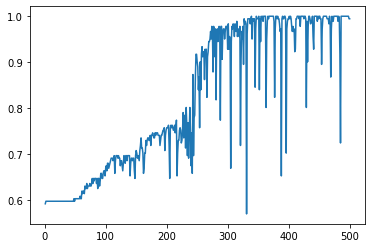

In [149]:
plt.plot([i+1 for i in range(len(accuracy_train_hist))],accuracy_train_hist)
max(accuracy_train_hist)

1.0

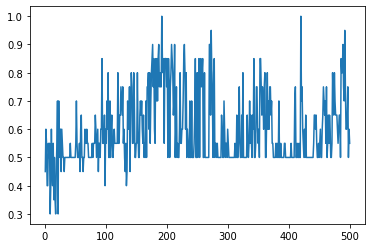

In [150]:
plt.plot([i+1 for i in range(len(accuracy_val_hist))],accuracy_val_hist)
max(accuracy_val_hist)

In [151]:
lstm1.load_state_dict(best_model_wts)

<All keys matched successfully>

In [152]:
torch.save(lstm1.state_dict(), '/content/best_model.pt')

In [153]:
import shutil
shutil.copyfile('/content/best_model.pt','/content/drive/MyDrive/CNN_LSTM/best_model.pt')

'/content/drive/MyDrive/CNN_LSTM/best_model.pt'

In [155]:
torch.save(torch.tensor(loss_train_hist),'/content/loss_train_hist.pt')
shutil.copyfile('/content/loss_train_hist.pt','/content/drive/MyDrive/CNN_LSTM/loss_train_hist.pt')

'/content/drive/MyDrive/CNN_LSTM/loss_train_hist.pt'

In [156]:
torch.save(torch.tensor(loss_test_hist),'/content/loss_test_hist.pt')
shutil.copyfile('/content/loss_test_hist.pt','/content/drive/MyDrive/CNN_LSTM/loss_test_hist.pt')

'/content/drive/MyDrive/CNN_LSTM/loss_test_hist.pt'

In [157]:
torch.save(torch.tensor(accuracy_train_hist),'/content/accuracy_train_hist.pt')
shutil.copyfile('/content/accuracy_train_hist.pt','/content/drive/MyDrive/CNN_LSTM/accuracy_train_hist.pt')

'/content/drive/MyDrive/CNN_LSTM/accuracy_train_hist.pt'

In [158]:
torch.save(torch.tensor( accuracy_val_hist),'/content/accuracy_val_hist.pt')
shutil.copyfile('/content/accuracy_val_hist.pt','/content/drive/MyDrive/CNN_LSTM/accuracy_val_hist.pt')

'/content/drive/MyDrive/CNN_LSTM/accuracy_val_hist.pt'